## The Perceptron
#### Gavin Daves, Rice University
#### INDE 577, Dr. Randy Davila

In this notebook, we will build a perceptron class in Python and then use it on the Spotify dataset.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import sys
from sklearn.model_selection import train_test_split

sns.set_theme()

In [22]:
# The Perceptron class

class Perceptron:
    """
    This class represents a Perceptron classifier.
    """
    def __init__(self, learning_rate=0.5, epochs=50):
        """
        Initializes the Perceptron classifier.

        Args:
            learning_rate: a number between 0 and 1 representing the learning rate of the perceptron. 
            Defaults to 0.5.
            epcohs: an integer representing the maximum number of iterations. Defaults to 50.
        """
        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self, X, y):
        """
        Trains the Perceptron classifier.

        Args:
            X: a 2D numpy array representing the input data.
            y: a 1D numpy array representing the target data.

        Returns:
            self: the trained Perceptron classifier.
        """
        self.weights_ = np.random.rand(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.learning_rate * (self.predict(xi) - target)
                self.weights_[:-1] -= update*xi
                self.weights_[-1] -= update
                errors += int(update != 0)
            self.errors_.append(errors)
            if errors == 0:
                return self
            
        return self
    
    def net_input(self, X):
        return np.dot(X, self.weights_[:-1]) + self.weights_[-1]
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)
    
    def get_weights(self):
        return self.weights_

### Background

I decided that it would be interesting to investigate if we can predict if a song is made by a certain rock artist based on how popular and how happy the song is. When looking into the provided data in the dataset, I found this about the valence column in the dataset's description:

- *valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)*

So, by minimizing and maximizing the average valence of all artists, we can respectively find the saddest and happiest-sounding rock artists. Then, given data of popularity and valence, we can train a Perceptron to predict whether a song is the "happy" artist or the "sad" artist.

In [3]:
# Loading and analyzing the data

# Add the top-level directory to the system path
sys.path.append('../../')

# Load the data
import clean_data as sd

df = sd.get_df()

# Get the rock songs
rock_df = df[df['track_genre'].str.contains('rock', case=False)]

# Find the average valence of each rock artist
sum_valence = defaultdict(int)
total_songs = defaultdict(int)

for i in rock_df['Unnamed: 0']:
    sum_valence[rock_df['artists'][i]] += rock_df['valence'][i]
    total_songs[rock_df['artists'][i]] += 1

average_valence = {k: v / total_songs[k] for k, v in sum_valence.items() if total_songs[k] > 20}

# Find the happiest and saddest rock artists

high_valence = max(average_valence, key=average_valence.get)
low_valence = min(average_valence, key=average_valence.get)

print(f"The happiest-sounding rock artist is {high_valence} with an average valence of {average_valence[high_valence]}")
print(f"The saddest-sounding rock artist is {low_valence} with an average valence of {average_valence[low_valence]}")
    

The happiest-sounding rock artist is Mike Laure with an average valence of 0.89176
The saddest-sounding rock artist is Pink Floyd with an average valence of 0.2796924242424243


Text(0.5, 1.0, 'Popularity vs Valence of Rock Artists')

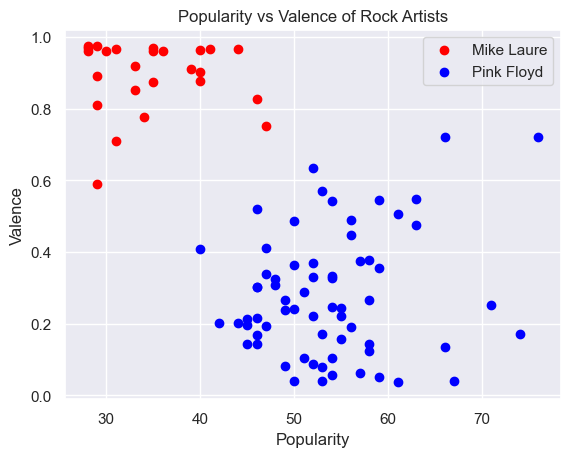

In [4]:
# Plotting the data (popularity vs valence)
happy_df = rock_df[rock_df['artists'] == high_valence]
sad_df = rock_df[rock_df['artists'] == low_valence]

plt.scatter(happy_df['popularity'], happy_df['valence'], color='red', label=high_valence)
plt.scatter(sad_df['popularity'], sad_df['valence'], color='blue', label=low_valence)
plt.xlabel('Popularity')
plt.ylabel('Valence')
plt.legend(loc='upper right')
plt.title('Popularity vs Valence of Rock Artists')

In [25]:
# Train the perceptron

# Join the two dataframes
joint_df = pd.concat([happy_df, sad_df])

X = joint_df[['popularity', 'valence']].values
y = np.where(joint_df['artists'] == high_valence, 1, -1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
ppn = Perceptron(learning_rate=0.05, epochs=1_000)
ppn.train(X_train, y_train)

# Test the perceptron
y_pred = ppn.predict(X_test)
print('Misclassified samples: %d' % (y_test != y_pred).sum())


Misclassified samples: 0


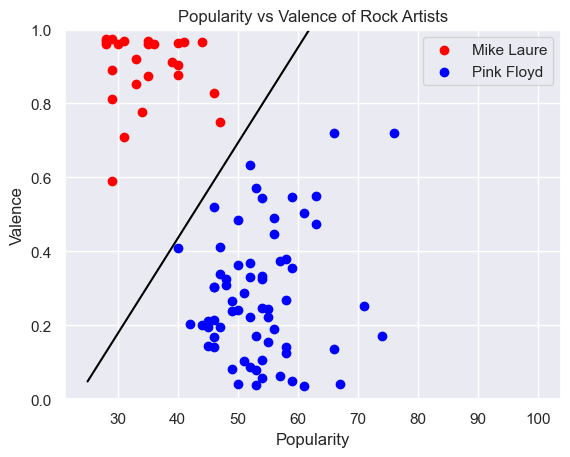

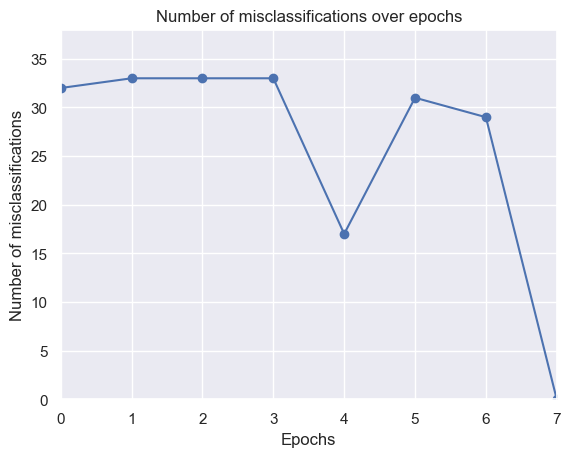

In [27]:
# Plot the decision boundary

plt.scatter(happy_df['popularity'], happy_df['valence'], color='red', label=high_valence)
plt.scatter(sad_df['popularity'], sad_df['valence'], color='blue', label=low_valence)
plt.xlabel('Popularity')
plt.ylabel('Valence')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.title('Popularity vs Valence of Rock Artists')

x1 = np.linspace(25, 100, 100)
x2 = (-ppn.get_weights()[2] - ppn.get_weights()[0]*x1) / ppn.get_weights()[1]

plt.plot(x1, x2, color='black')
plt.show()

# Plot Missclassifications over epochs

plt.plot(range(0, len(ppn.errors_)), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.xlim(0, len(ppn.errors_)-1)
plt.ylim(0, max(ppn.errors_)+5)
plt.title('Number of misclassifications over epochs')
plt.show()

### Error Analysis

As can be seen in the plot, there is a separating line between the two classes of data (meaning the data is linearly separable) and the perceptron did not misclassify any samples. Further, in the second plot, we can see that over time, there is a general decrease in misclassifications. Overall, the accuracy and simplistic nature of the perceptron makes it a good classifier of valence between these two rock artists.